In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy

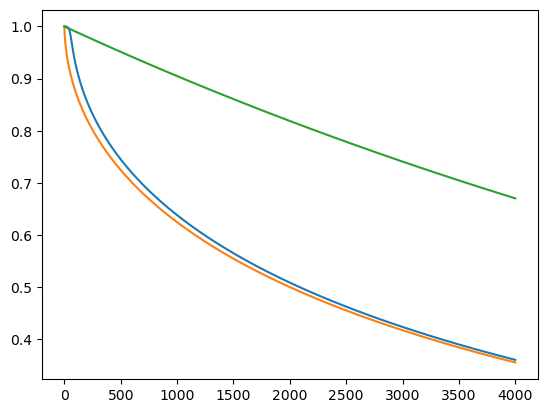

In [2]:
ka = 10
kd = 0.01
pt = 1
k1 = 0.1

def dpl2(pl):
    return -pl*kd*k1/(k1+ka*(pt-pl))

def pl_flux(pl, lm):
    return ka*(pt - pl)*lm - kd*pl

#integrator settings
dt = 0.02
tmax = 200000

#initial conditions
lm = 10

pl = pt*lm/(lm+kd/ka)
pl2 = pl

#data collection
pl2_trj = [pl2]

pl_trj = [pl]
lm_trj = [lm]
t_trj = [0]

analytic = [pl]

for t in range(tmax):
    pl += pl_flux(pl,lm)*dt
    lm += (-k1*lm - pl_flux(pl,lm))*dt

    t_trj.append((t+1)*dt)
    pl_trj.append(pl)
    lm_trj.append(lm)

    pl2 += dpl2(pl2)*dt

    pl2_trj.append(pl2)

    analytic.append(pl_trj[0]*np.exp(-t*dt*kd*k1/(ka*pt)))

plt.plot(t_trj, pl_trj)
#plt.plot(t_trj, lm_trj)

plt.plot(t_trj, pl2_trj)

plt.plot(t_trj, analytic)

#plt.yscale("log")

In [3]:
#ka*pt must exceed k1 for the results to be useful, but large ka*pt also delays the time when it becomes a reliable approximation.

In [4]:
#fit an exponential and see what the optimal tau is as a function of k-a, ka, and k1, 
#and then try to come up with an expression for the optimal tau and see if the ratio reduces to anything usable

In [8]:
#x and y here are not the same as above
#this is used to solve x = f(y, params) at fixed x intervals dx
def solve_implicit_at_fixed_intervals(x_y, dy_dx_y, params, y0, y1, dx, tolerance=-1):
    
    if tolerance == -1:
        tolerance = dx/100
    
    x_trj = []
    y_trj = []
    
    y = y0
    while y >= y1:
        y_trj.append(y)
        x_trj.append(x_y(y, *params))

        #linear estimate of y step that will yield desired time step
        dy = dy_dx_y(y, *params)*dx
        if y+dy <= 0: #this is needed because our current expression x(y) contains a logarithm
            dy = -y/2

        dy_over = dy
        dy_under = 0

        #check if x step is actually right and adjust otherwise
        while abs(abs(x_y(y+dy, *params)-x_trj[-1])-dx) > tolerance:
            if abs(x_y(y+dy, *params)-x_trj[-1])-dx > tolerance:
                dy_over = dy
                dy = (dy_over + dy_under)/2
            elif abs(x_y(y+dy, *params)-x_trj[-1])-dx < -tolerance:
                dy_under = dy
                dy = (dy_over + dy_under)/2  
                                
        y += dy
        
    return x_trj, y_trj

In [9]:
def t_x(x, kd, ka, pt, k1):
    return (-(k1 + ka*pt)*np.log(x) + ka*pt*(x-1))/(kd*k1)

def dx_dt_x(x, kd, ka, pt, k1):
    return -x*kd*k1/(k1 + ka*pt*(1-x))

# def ddx_dt2_x(x, kd, ka, pt, k1):
#     return x*(kd*k1)**2/(k1 + ka*pt*(1-x))**3 * (k1 + ka*pt)

0.001
0.01
0.1
1.0


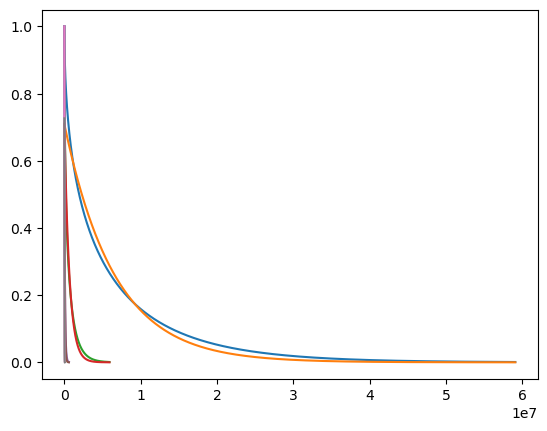

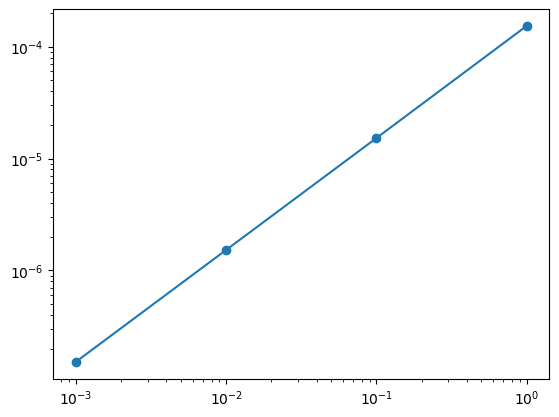

0.00015239734345481304
0.0001
1.5239734345481304


In [29]:
kd = 0.01
ka = 100
pt = 1
#k1 = 0.01

#k_exp = m*k1*kd/(ka*pt), where m is about 1.52. 
#This is independent of the data length in the limit of t--> inf,
#but not in the limit of t-->0 

x0 = 1
x1 = 0.001
dt = 100

k1s = []
taus = []
lasttau = 0

check_timesteps = False

for lnk1 in np.arange(-3, 1, 1):
    
    k1 = 10.0**lnk1
    
    params = (kd, ka, pt, k1)
    k1s.append(k1)    
    print(k1)
    
    t, x = solve_implicit_at_fixed_intervals(t_x, dx_dt_x, params, x0, x1, dt, tolerance=-1)
    plt.plot(t,x)
    #plt.show()

    if check_timesteps:
        #verify uniform timesteps
        delta_t = [t[i+1]-t[i] for i in range(len(t)-1)]
        plt.plot(t[0:-1], delta_t)
        plt.show()

    #direct exponential least squares fit
    cf = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  t,  x, p0=(1, lasttau))
    taus.append(-cf[0][1])
    lasttau = cf[0][1]

    #plot exponential fit
    xexp = [cf[0][0]*np.exp(cf[0][1]*ti) for ti in t]

    plt.plot(t, xexp)
    #plt.show()

plt.show()

plt.scatter(k1s, taus)
plt.plot(k1s, taus)
plt.xscale("log")
plt.yscale("log")
plt.show()

slope = (taus[2]-taus[0])/(k1s[2]-k1s[0])
print(slope)
hyp = k1*kd/(ka*pt)
print(hyp)
print(slope/hyp)

In [ ]:
ka = 500
kd = 0.001
pt = 1 #equivalent to changing ka as the two always co-occur as a product

k1s = []
taus = []

forward = False

lasttau = 0

for lnk1 in np.arange(-3, 2, 1):

    try:

        k1 = 10.0**lnk1
        k1s.append(k1)
        print(k1)
    
        t = []
        x = []

        if forward:
            for i in range(0,1000000, 1000):
                t.append(i)

                def f(x, t, k1, ka, kd, pt):
                    return kd*k1*t + (k1+ka*pt)*np.log(x) - ka*pt*(x-1)
                x.append(fsolve(f, 0.02, args = (i, k1, ka, kd, pt), maxfev = 500)[0])

        else:
            dt = 10
            xi = 1
            while xi > 0.95:
                x.append(xi)
                t.append((-(k1+ka*pt)*np.log(xi) + ka*pt*(xi-1))/(kd*k1))
                #increment x by an amount that will yield a constant time step
                xi += dt*-xi*kd*k1/(k1+ka*pt*(1-xi))
                
                #also make this into a utility method for implicit functions of the form f(x) = t
                #TODO: after incrementing xi check that this will actually yield the desired time to within tolerance; otherwise do bisection search between xi and 1 until it does
#                 print(xi)
#                 break
                
            plt.plot([t[i+1]-t[i+0] for i in range(len(t)-2)])
            plt.show()
            print(t[0:5])
            
            import sys
            sys.exit(0)
            
        plt.plot(t,x)
        #plt.show()
        #break

        #print(t)
        #print(x)

        if lasttau == 0:
            lasttau = -10**-12 #-kd*k1/(ka*pt)
    
        cf = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  t,  x, p0=(1, lasttau))
        #print(cf[0])
        #break
        taus.append(-cf[0][1])
        lasttau = cf[0][1]
        
        #print(cf[0][0])
        
        texp = []
        xexp = []
        
        if forward:
            for i in range(0,1000000, 100):
                texp.append(i)
                xexp.append(cf[0][0]*np.exp(cf[0][1]*i))
        
        else:
            for ti in t:
                texp.append(ti)
                xexp.append(cf[0][0]*np.exp(cf[0][1]*ti))
            #for xi in np.arange(cf[0][0],0.001,-0.001):
                #xexp.append(xi)
                #texp.append((1/cf[0][1])*np.log(xi/cf[0][0]))
            
            
        plt.plot(texp, xexp)
        
        delta_x = [xexpi-xi for xi, xexpi in zip(x, xexp)]
        plt.plot([0,max(t)], [0,0])
        plt.plot(t, delta_x)
        
        
        #plt.yscale("log")
        plt.show()
        
        #print(texp)
        #break
    except Exception as e:
        print(e)
        break
        
        #print("error")
        #pass
    
plt.plot(k1s, taus)
plt.scatter(k1s, taus)
#plt.xscale("log")
#plt.yscale("log")

plt.xlabel("k1")
plt.ylabel("tau")
#plt.xlim(0,0.1)
#plt.ylim(-0.01, 0)

#next fit a curve to this line and figure out what the slope is

In [ ]:
taus